# Customer Churn Prediction with Random Forest and XGBoost

Predicting customer churn is a crucial task for companies that rely on subscriptions or long-term customers. In this project, we'll build machine learning models that can predict whether a customer is likely to stop using a service ("churn").

We'll work with the popular **Telco Customer Churn Dataset** and go through every step of building a predictive model:

- Data exploration and visualization
- Data preprocessing and encoding
- Training a Random Forest Classifier
- Training an XGBoost Classifier
- Analyzing feature importance
- Hyperparameter tuning
- Evaluating and comparing models


## Step 1. Import Required Libraries

In [62]:
# Basic tools for data analysis
import pandas as pd
import numpy as np

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning models and tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# XGBoost library
import xgboost as xgb

# Label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder

# Suppress warnings for cleaner output
import warnings

warnings.filterwarnings('ignore')

# Set visual style for plots
sns.set(style='whitegrid')

## Step 2. Dataset Overview

In this project, we'll use the [**Telco Customer Churn dataset**](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset) provided by IBM. The dataset includes customer information such as:

- Demographics (gender, age, partner, dependents)
- Account details (tenure, contract, paperless billing)
- Services signed up (internet, phone, multiple lines, streaming)
- Payment and billing (monthly charges, total charges, payment method)
- Whether or not the customer **churned**

Each row represents one customer. The target variable is the `Churn` column, which is either "Yes" or "No".

We'll begin by loading and inspecting the dataset.


In [63]:
# Load dataset
df = pd.read_csv('telco-customer-churn.csv')

# Show basic information of the dataset
print(f"Dataset Shape (rows, columns): {df.shape}")
df.head()

Dataset Shape (rows, columns): (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Step 3: Exploratory Data Analysis (EDA)

Before building any models, it's important to explore the dataset:

- Understand the size and structure of the data
- Detect any missing values or incorrect data types
- Understand the distribution of the target column (`Churn Label`)
- Analyze how churn varies across key features like contract type, monthly charges, internet service, etc.

This will help us decide which features might be most useful for prediction.

In [64]:
# Show column names and data types
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

In [65]:
# Check for missing values
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [66]:
# See basic summary for numerical columns
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


## Step 4: Explore Target Variable (`Churn Label`)

The column `Churn Label` is our **target variable**. It tells us whether a customer **churned** (`"Yes"`) or **did not churn** (`"No"`).

Before building a model, we need to:
- Check the **balance** of the classes
- Visualize how many customers churned vs didn’t
- Understand if there’s any **class imbalance** (which might require handling)

Let’s explore the distribution.


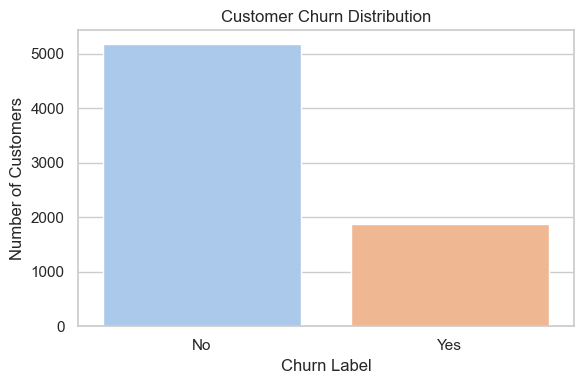

Churn Counts:
 Churn Label
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentages:
 Churn Label
No     73.46
Yes    26.54
Name: count, dtype: float64


In [67]:
# Count values in the target column
churn_counts = df['Churn Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='pastel')
plt.title('Customer Churn Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Churn Label')
plt.tight_layout()
plt.show()

# Print counts and percentages
print("Churn Counts:\n", churn_counts)
print("\nChurn Percentages:\n", round((churn_counts / len(df)) * 100, 2))

### What This Tells Us:
Out of `7,043` customers, about `26.5%` have churned and `73.5%` have stayed.

This is a class imbalance, though not extreme — still important to be aware of for model training and evaluation.

We'll address this during modeling by using evaluation metrics beyond accuracy (like precision, recall, F1-score) and possibly balanced class weights if needed.

## Step 5: Drop Irrelevant or Redundant Columns

Certain columns won’t help our machine learning model and should be removed:

- `CustomerID`: Just an identifier — not useful for learning patterns
- Location details: `City`, `Zip Code`, `Latitude`, `Longitude`, `Lat Long` – not meaningful for churn prediction
- Post-churn data: `Churn Reason`, `Churn Score`, and `CLTV` — these are outcomes of churn, not predictors

Removing them helps keep the model clean and focused only on useful input features.

In [68]:
# List of columns to drop
columns_to_drop = ['CustomerID', 'Lat Long', 'Latitude', 'Longitude', 'Zip Code', 'City', 'State', 'Country',
                   'Churn Reason', 'Churn Score', 'CLTV', 'Count', 'Churn Value']

# Drop them from the dataset
df_cleaned = df.drop(columns=columns_to_drop)

# Confirm changes
print("Remaining columns:", df_cleaned.columns.tolist())
print("\nNew shape:", df_cleaned.shape)

Remaining columns: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label']

New shape: (7043, 20)


## Step 6: Encoding Categorical Variables

Machine learning models like Random Forest and XGBoost require **numerical input**. That means we need to convert all **categorical columns** (text like "Yes"/"No", "Male"/"Female", etc.) into numbers.

We'll use:
- **Label Encoding**: For binary columns (e.g., `Yes`/`No`, `Male`/`Female`)
- **One-Hot Encoding** (optional): For categorical columns with more than 2 values

In this project, we’ll use **LabelEncoder** to keep things simple and avoid creating too many columns.


In [69]:
# Make a copy of the cleaned data so that we don't change the original cleaned data
df_encoded = df_cleaned.copy()

# Loop through all the columns and apply LabelEncoder if its a string (object)
label_encoders = {}

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

# Confirm all columns are now numeric
print(df_encoded.dtypes.value_counts())
print("\nEncoded dataset preview:")
df_encoded.head()

int64      19
float64     1
Name: count, dtype: int64

Encoded dataset preview:


,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label
0,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
1,0,0,0,1,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1
2,0,0,0,1,8,1,2,1,0,0,2,0,2,2,0,1,2,99.65,6104,1
3,0,0,1,1,28,1,2,1,0,0,2,2,2,2,0,1,2,104.80,2646,1
4,1,0,0,1,49,1,2,1,0,2,2,0,2,2,0,1,0,103.70,4265,1


## Step 7: Split Data into Training and Testing Sets

Before we train any machine learning model, we need to **split our dataset** into two parts:

- **Training Set**: Used to train the model (typically 70–80% of the data)
- **Testing Set**: Used to evaluate how well the model performs on unseen data

We'll split the data in such a way that the **class balance** is preserved using `stratify=y`.

In [70]:
# Separate features (X) and target (y)
X = df_encoded.drop(columns=['Churn Label'])
y = df_encoded['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Show result
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 5634
Testing samples: 1409


## Step 8: Train a Random Forest Classifier

A **Random Forest** is an ensemble model that builds multiple decision trees and combines their outputs for better accuracy and robustness.

It works well for both classification and regression tasks, handles missing values, and is less prone to overfitting than a single decision tree.

We’ll start with:
- Training the model using default parameters
- Making predictions on the test set
- Evaluating accuracy, precision, recall, F1-score, and confusion matrix

In [71]:
# Create and train the model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_pred = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Performance\n")

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

Random Forest Performance

Accuracy: 0.7955997161107168

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.80      0.79      1409

Confusion Matrix:
[[935 100]
 [188 186]]


### Interpretation
- The model is doing well on identifying customers who did not churn, but still struggles to catch many churners.

- That’s normal — churn is harder to predict due to its imbalanced nature and more complex patterns.

## Step 9: Train an XGBoost Classifier (Default Settings)

**XGBoost** (Extreme Gradient Boosting) is one of the most powerful and widely used gradient boosting algorithms. It builds trees in sequence, where each new tree corrects the errors of the previous ones.

We'll:
- Train an XGBoost model with default parameters
- Make predictions on the test set
- Evaluate it using accuracy, precision, recall, F1-score, and confusion matrix

In [72]:
# Create and train the XGBoost classifier with default settings
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions using test data
xgb_pred = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classifier Performance (Default)\n")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_pred))

XGBoost Classifier Performance (Default)

Accuracy: 0.7892122072391767

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
[[913 122]
 [175 199]]


### Interpretation:
- XGBoost performs similarly to Random Forest (slightly lower accuracy but slightly better on true churn detection — 199 vs 186).

- It's still missing a fair number of churners (175 false negatives), which we may reduce through hyperparameter tuning.

## Step 10: Feature Importance from XGBoost

One of the strengths of tree-based models like XGBoost is that they provide **feature importance scores**.

These scores show how valuable each feature was in building the model. The higher the score, the more the feature contributed to decisions across the trees.

Let’s extract and plot the top features.


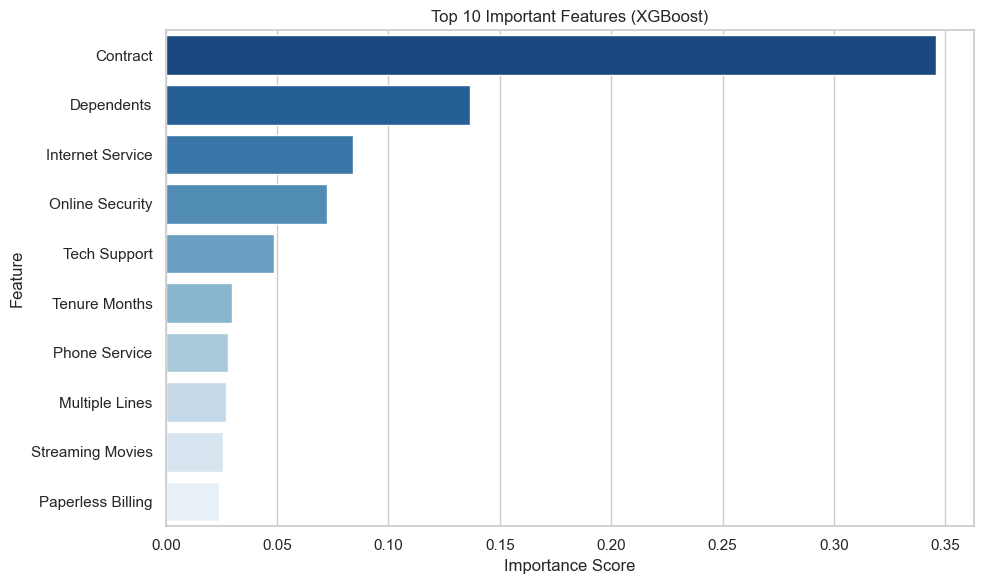

Top 10 Features:
               Feature  Importance
14           Contract    0.345619
3          Dependents    0.136436
7    Internet Service    0.084142
8     Online Security    0.072561
11       Tech Support    0.048637
4       Tenure Months    0.029875
5       Phone Service    0.027800
6      Multiple Lines    0.026922
13   Streaming Movies    0.025544
15  Paperless Billing    0.024040


In [73]:
# Get feature importance from XGBoost model
importance_scores = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='Blues_r')
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Features:\n", importance_df.head(10))

### Summary of Feature Importance

The XGBoost model highlighted the top drivers of customer churn:

- **Contract** had the highest influence — customers on month-to-month plans are more likely to churn than those on long-term contracts.
- **Dependents** mattered — customers with dependents tend to be more stable and less likely to churn.
- **Internet Service**, **Online Security**, and **Tech Support** showed that customers using more services or support features are more engaged and likely to stay.
- **Tenure** and **Multiple Lines** reflected customer commitment — longer tenure or more lines suggest higher loyalty.
- Features like **Streaming Movies** and **Paperless Billing** had smaller impacts but still showed patterns of customer preferences and behaviors.

Understanding these features can help businesses reduce churn by improving contracts, services, and support.

## Step 11: Hyperparameter Tuning with RandomizedSearchCV

To improve our XGBoost model's performance, we'll tune its hyperparameters using `RandomizedSearchCV`.

Unlike Grid Search (which tries every possible combination), **Randomized Search** tests a random selection of combinations — it's much faster and still effective for large search spaces.

We'll tune the following parameters:
- `n_estimators`: Number of trees
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `subsample`: Row sampling per tree
- `colsample_bytree`: Feature sampling per tree
- `gamma`: Minimum loss reduction for splitting
- `reg_lambda`: L2 regularization

In [74]:
# Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [0, 1, 5, 10]
}

# Initialize the classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters Found:\n", random_search.best_params_)
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters Found:
 {'subsample': 0.6, 'reg_lambda': 10, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}


## Step 12: Evaluate Tuned XGBoost on Test Set

We’ll now use the best model from RandomizedSearchCV to make predictions on the test set and evaluate its performance using accuracy, precision, recall, F1-score, and the confusion matrix.

In [75]:
# Make predictions with the tuned model
xgb_best_preds = best_xgb.predict(X_test)

# Evaluate tuned XGBoost
print("Tuned XGBoost Performance\n")
print("Accuracy:", accuracy_score(y_test, xgb_best_preds))
print("\nClassification Report:")
print(classification_report(y_test, xgb_best_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_best_preds))

Tuned XGBoost Performance

Accuracy: 0.8062455642299503

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix:
[[936  99]
 [174 200]]


## Final Model Evaluation Summary

After training and evaluating multiple models, we selected the best one using performance metrics like accuracy, precision, recall, F1-score, and the confusion matrix.

### Summary of Model Performance

| Model                   | Accuracy | F1-Score (Churn) | False Positives | False Negatives |
|------------------------|----------|------------------|------------------|------------------|
| Random Forest (Default) | 79.6%    | 0.56             | 100              | 188              |
| XGBoost (Default)       | 78.9%    | 0.57             | 122              | 175              |
| **XGBoost (Tuned)**     | **80.6%**| **0.59**         | 99               | 174              |

### Key Takeaways

- The **tuned XGBoost model** achieved the **best overall performance**, improving both precision and recall for detecting churned customers.
- It strikes a better balance between identifying churners (recall) and minimizing false alarms (precision).
- Feature importance analysis revealed that factors like `Contract`, `Dependents`, and `Internet Service` are strong churn indicators.
- This approach demonstrates how **tree ensemble models**, when properly tuned, can be powerful tools for business-critical tasks like churn prediction.

### Final Decision

We’ll use the **tuned XGBoost model** as our production candidate for churn prediction.